# 00-Basic example using MOGPTK

_[Estimated time of execution: 5 min]_

This notebook shows the basics of MOGPTK: how to quickly load data and train a model.

The fundamental pillars of MOGPTK are the `mogptk.Data` and `mogptk.Model` classes, where the former stores the data for each channel and the latter defines the model to use. In this tutorial we will show how to use them in a toy dataset.

This tutorial shows examples for the following covariance kernels:

* __[MOSM](https://games-uchile.github.io/mogptk/mosm.html)__ MultiOutput Spectral Mixture
*  __[CONV](https://games-uchile.github.io/mogptk/conv.html)__ Convolutional Gaussian
* __[CSM](https://games-uchile.github.io/mogptk/csm.html)__ Cross Spectral Mixture
* __[SM-LMC](https://games-uchile.github.io/mogptk/sm_lmc.html)__ Spectral Mixture - Linear Model of Corregionalization

Full documentation can be accessed here:
[__Documentation__](https://games-uchile.github.io/mogptk/)

In [1]:
import mogptk

import numpy as np
import matplotlib.pyplot as plt

## Generating a toy dataset

As a toy example we generate __four noisy sinusoidal signals__, each of which is of the same frequency but they differ in phase and delay as follows

In [2]:
# create time array
n_points = 100
t = np.linspace(0.0, 6.0, n_points)

# channel 1
y1 = np.sin(6.0*t) + 0.2*np.random.normal(size=len(t))

# channel 2, phased version
y2 = np.sin(6.0*t + 2.0) + 0.2*np.random.normal(size=len(t))

# channel 3, added sinosoidal
y3 = np.sin(6.0*t) - np.sin(4.0*t) + 0.2*np.random.normal(size=len(t))

# channel 4, delayed and amplified
y4 = 3.0*np.sin(6.0 * (t-2.0)) + 0.3*np.random.normal(size=len(t))

Then for each time series (channels) we will instantiate a [`mogptk.Data`](https://games-uchile.github.io/mogptk/data.html) class object, which will be used to create a dataset instance [`mogptk.DataSet`](https://games-uchile.github.io/mogptk/dataset.html) to be passed to the model.

More examples of data loading are in [01-Data Loading](https://github.com/GAMES-UChile/mogptk/blob/master/examples/01_Data_Loading.ipynb).

In [3]:
# data object for each channel
data1 = mogptk.Data(t, y1, name='First channel')
data2 = mogptk.Data(t, y2, name='Second channel')
data3 = mogptk.Data(t, y3, name='Third channel')
data4 = mogptk.Data(t, y4, name='Fourth channel')

# create dataset
dataset = mogptk.DataSet(data1, data2, data3, data4)

### Removing data to generate observations
Then we can remove the second half of the first channel with [`mogptk.Data.remove_range`](https://games-uchile.github.io/mogptk/data.html#mogptk.data.Data.remove_range). Then we randomly remove 40% for all channels using the method [`mogptk.Data.remove_randomly`](https://games-uchile.github.io/mogptk/data.html#mogptk.data.Data.remove_randomly).

More examples are in [02-Data Preparation](https://github.com/GAMES-UChile/mogptk/blob/master/examples/02_Data_Preparation.ipynb).

In [4]:
# remove 40% randomly
for data in dataset:
    data.remove_randomly(pct=0.4)

# remove second half of the first channel
dataset[0].remove_range(start=2.0)

We can plot the signal in the time domain with [`mogptk.DataSet.plot`](https://games-uchile.github.io/mogptk/dataset.html#mogptk.dataset.DataSet.plot).

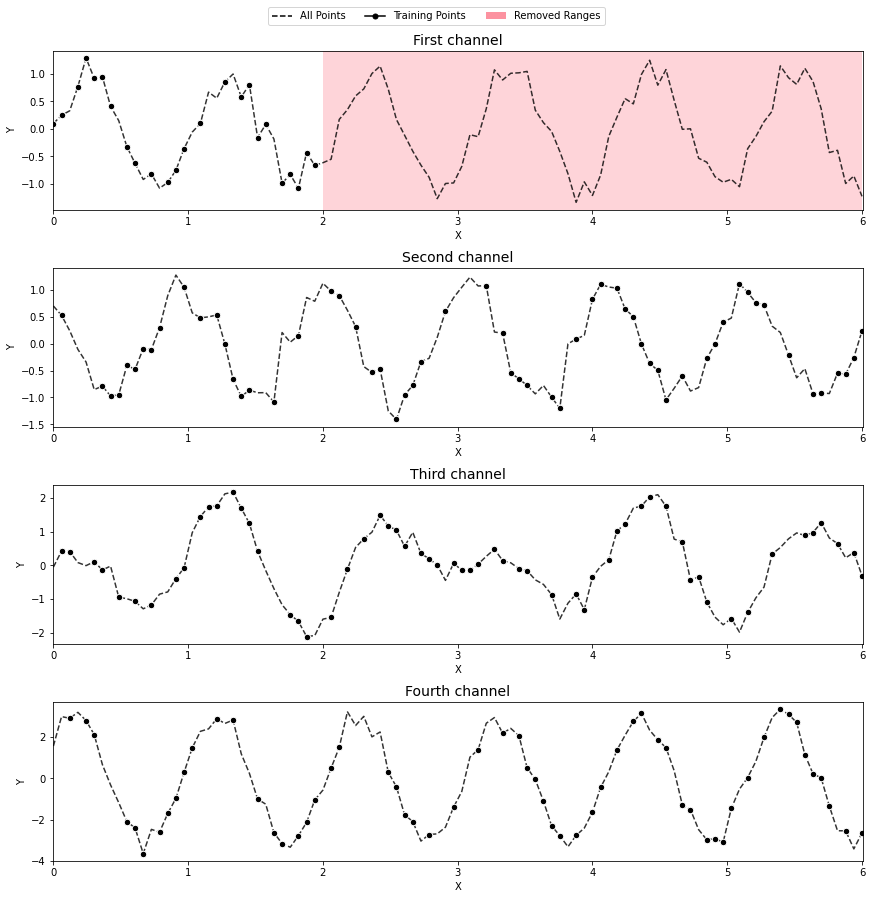

In [5]:
dataset.plot();

And we can plot the spectrum with [`mogptk.Data.plot_spectrum`](https://games-uchile.github.io/mogptk/data.html#mogptk.data.Data.plot_spectrum) using the Lomb-Scargle method.

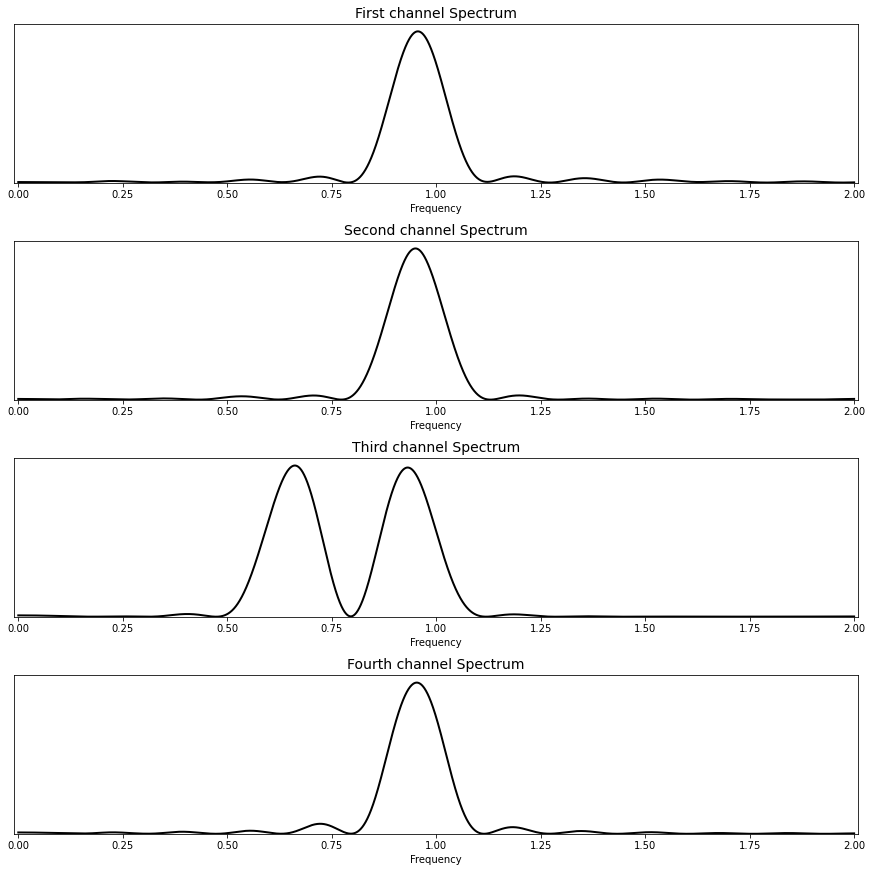

In [6]:
dataset.plot_spectrum(maxfreq=2);

## Models

To use a model we first create an `mogptk.Model` object, then we can initialize the parameters with sound heuristics and to assist optimization.

When creating the `mogptk.Model` object, we pass the dataset and the number of components (or model order). Initially, the kernel parameters are drawn from a Unif(0, 1), but we can __optionally__ re-initialize them to help the optimization by:

1. BNSE: Estimate the PSD for each channel via BNSE (Bayesian nonparametric spectral estimation, Tobar 2019), then utilize the position, magnitude and width of the **estimated spectrum peaks** as spectral means, weights and variance respectively.

2. SM: For each channel fit a single output Gaussian process with aspectral mixture kernel (Gaussian process kernels for pattern discovery and extrapolation, Wilson and Adams 2013), and use said hyperparameters as initial parameters for the kernel.

3. LS: Estimate the PSD for each channel via Lomb-Scargle, then utilize the position, magnitude and width of the **estimated spectrum peaks** as spectral means, weights and variance respectively.

This is done using the `model.init_parameters()` function. See the documentation of each model or [03-Parameter initialization](https://github.com/GAMES-UChile/mogptk/blob/master/examples/03_Parameter_Initialization.ipynb) where each method is covered in more detail.

In [7]:
# create model, uncomment for different kernels 
model = mogptk.MOSM(dataset, Q=2)
# model = mogptk.CSM(dataset, Q=2)
# model = mogptk.SM_LMC(dataset, Q=2)
# model = mogptk.CONV(dataset, Q=2)

# initialize parameters of kernel using BNSE
model.init_parameters(method='BNSE')

In [8]:
model.print_parameters()

Name,Range,Value
Mixture[0].MOSM.noise,"[1e-08,∞)",[0.01705213 0.01686008 0.03532329 0.14592449]
Mixture[0].MOSM.magnitude,"[1e-08,∞)",[1.21629832 1.42239578 1.46157316 4.18460732]
Mixture[0].MOSM.mean,"[1e-08,∞)",[[0.0055991 ] [0.00574775] [0.00391441] [0.00574775]]
Mixture[0].MOSM.variance,"[1e-08,∞)",[[0.00496762] [0.0012599 ] [0.00144202] [0.00115468]]
Mixture[0].MOSM.delay,"(-∞,∞)",[[0.] [0.] [0.] [0.]]
Mixture[0].MOSM.phase,"(-∞,∞)",[0. 0. 0. 0.]
Mixture[1].MOSM.noise,"[1e-08,∞)",[0.01705213 0.01686008 0.03532329 0.14592449]
Mixture[1].MOSM.magnitude,"[1e-08,∞)",[7.52910294e-01 1.00000000e-08 1.45003394e+00 1.00000000e-08]
Mixture[1].MOSM.mean,"[1e-08,∞)",[[1.98198198e-03] [1.00000000e-08] [5.64864865e-03] [1.00000000e-08]]
Mixture[1].MOSM.variance,"[1e-08,∞)",[[2.89869741e-03] [1.00000000e-08] [1.46468830e-03] [1.00000000e-08]]


We can obtain a preliminary prediction __before__ training, just by using the pretrained (init) parameters. 

Predictions are done with [`mogptk.Model.predict`](https://games-uchile.github.io/mogptk/model.html#mogptk.model.Model.predict) which either receives or uses an input set with [`mogptk.DataSet.set_prediction_range`](https://games-uchile.github.io/mogptk/dataset.html#mogptk.dataset.DataSet.set_prediction_range) and returns the posterior mean and confidence intervals.

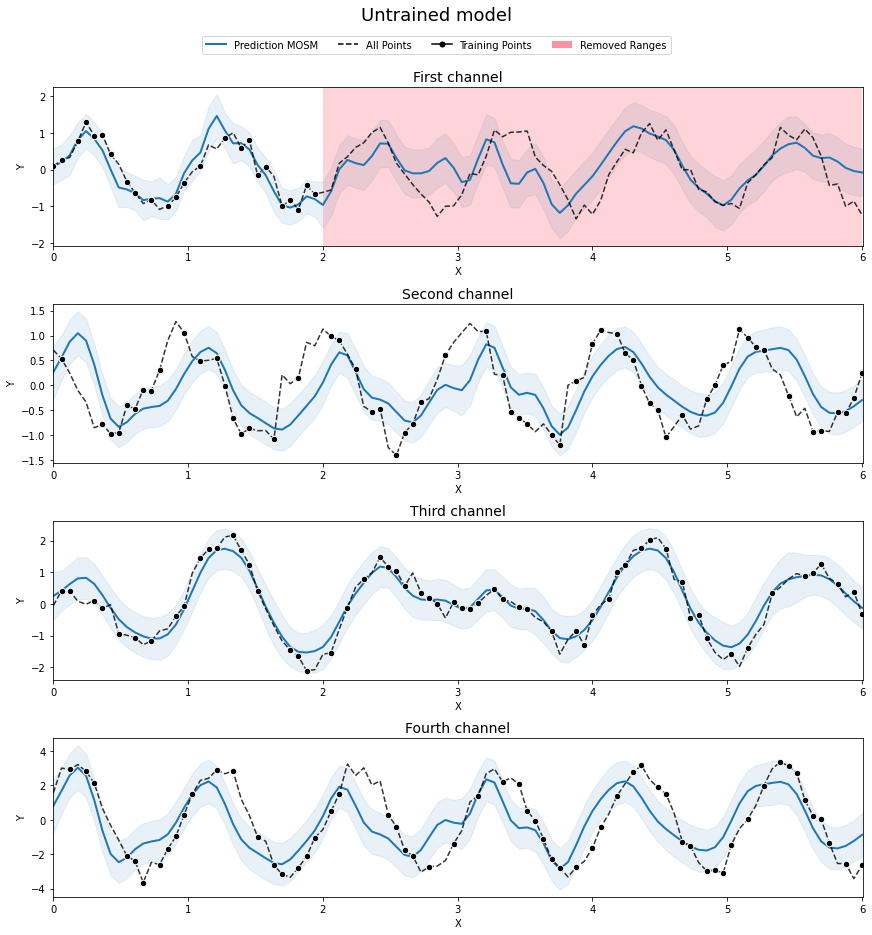

In [9]:
# plot the prediction with the untrained model
model.predict()
dataset.plot(title='Untrained model');

## Training
The model can be trained using PyTorch optimizers, such as LBFGS, Adam, or SGD. For more information see [04-Model Training](https://github.com/GAMES-UChile/mogptk/blob/master/examples/04_Model_Training.ipynb).

In [10]:
model.train(method='Adam', iters=500, verbose=True)


Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 4
‣ Mixtures: 2
‣ Training points: 204
‣ Parameters: 48
‣ Initial NLL: 2.423

Optimization finished in 0.48 minutes
‣ Function evaluations: 500
‣ Final NLL: 0.191


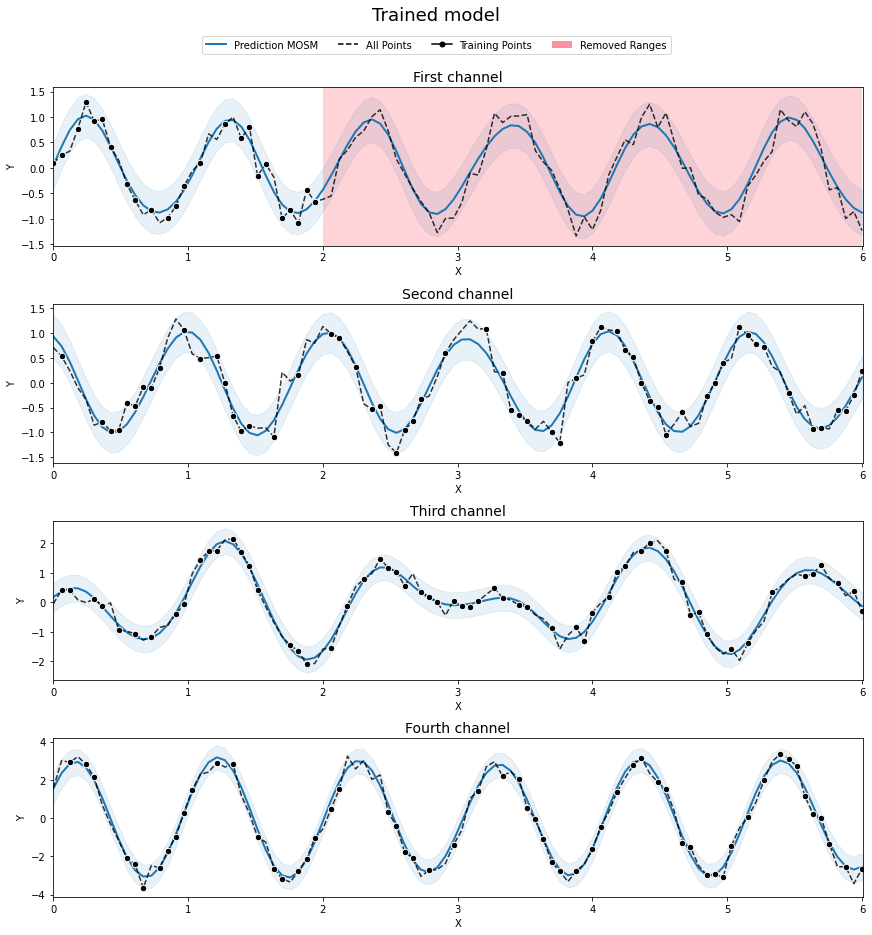

In [11]:
model.predict()
dataset.plot(title='Trained model');

## Prediction outside training range

Prediction can be made outside the training range easily using the [`mogptk.Model.predict`](https://games-uchile.github.io/mogptk/model.html#mogptk.model.Model.predict) function. For this we construct a list of numpy arrays with the prediction inputs and then pass it as an argument to [`mogptk.Model.predict`](https://games-uchile.github.io/mogptk/model.html#mogptk.model.Model.predict), so that we obtain the posterior mean and the upper and lower confidence intervals.

In [12]:
# we use the same time for all the channels
t_pred = np.linspace(6.0, 10.0, 100)
x_pred = [t_pred for i in range(len(dataset))]

model.predict(x_pred)

([array([[1000.        ],
         [1006.73400673],
         [1013.46801347],
         [1020.2020202 ],
         [1026.93602694],
         [1033.67003367],
         [1040.4040404 ],
         [1047.13804714],
         [1053.87205387],
         [1060.60606061],
         [1067.34006734],
         [1074.07407407],
         [1080.80808081],
         [1087.54208754],
         [1094.27609428],
         [1101.01010101],
         [1107.74410774],
         [1114.47811448],
         [1121.21212121],
         [1127.94612795],
         [1134.68013468],
         [1141.41414141],
         [1148.14814815],
         [1154.88215488],
         [1161.61616162],
         [1168.35016835],
         [1175.08417508],
         [1181.81818182],
         [1188.55218855],
         [1195.28619529],
         [1202.02020202],
         [1208.75420875],
         [1215.48821549],
         [1222.22222222],
         [1228.95622896],
         [1235.69023569],
         [1242.42424242],
         [1249.15824916],
         [12

The output of the function follows the same structure as the input, a list of length equal to the number of channels, where each element is a numpy array with the predictions on said channel.

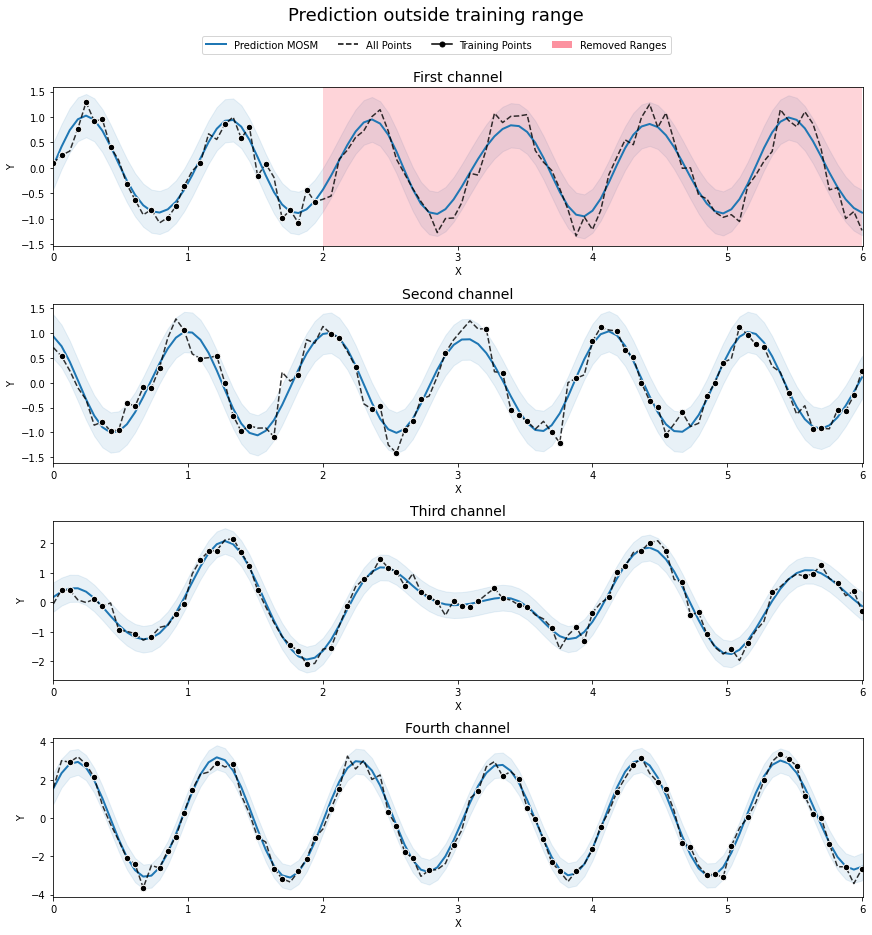

In [13]:
dataset.plot(title='Prediction outside training range');

## Data transformations

Currently the toolkit admits the following transformations on channels:

* Linear
* Normalize
* Polynomial detrending
* Logarithmic
* Standard

These can be applied successively (i.e., as a function composition) as the toolkit keeps track of them. New transformations are straightforward to create by implementing the forward and backward transformations for the data.

As an example we'll apply the exponential function to the original data for the first three channels and fit the model with the log-transformation for those channels. For more information and an example of how to construct new transformations see [02-Data Preparation](https://github.com/GAMES-UChile/mogptk/blob/master/examples/02_Data_Preparation.ipynb).

In [14]:
dataset2 = mogptk.DataSet()

dataset2.append(mogptk.Data(t, np.exp(y1), name='Signal 1'))
dataset2.append(mogptk.Data(t, np.exp(y2), name='Signal 2'))
dataset2.append(mogptk.Data(t, np.exp(y3), name='Signal 3'))
dataset2.append(mogptk.Data(t, y4, name='4'))

for data in dataset2:
    data.remove_randomly(pct=0.3)

dataset2[0].remove_range(start=2.0)

# apply transformation
for data in dataset2[:-1]:
    data.transform(mogptk.TransformLog)

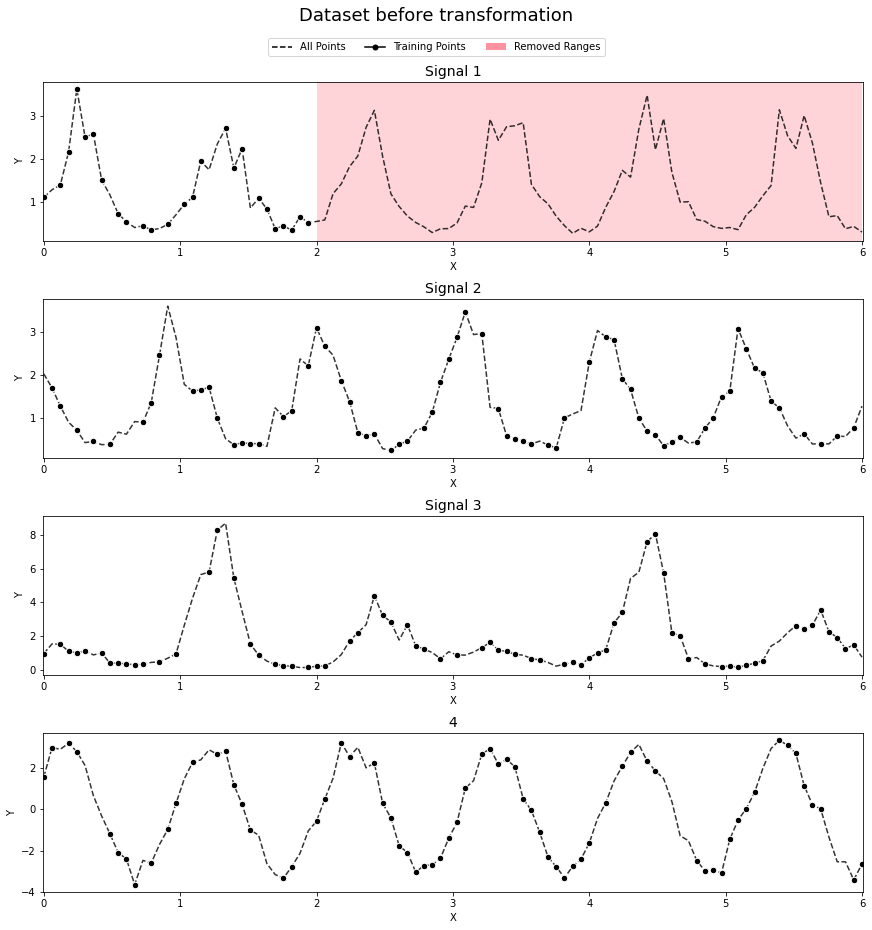

In [15]:
dataset2.plot(title='Dataset before transformation', transformed=False);

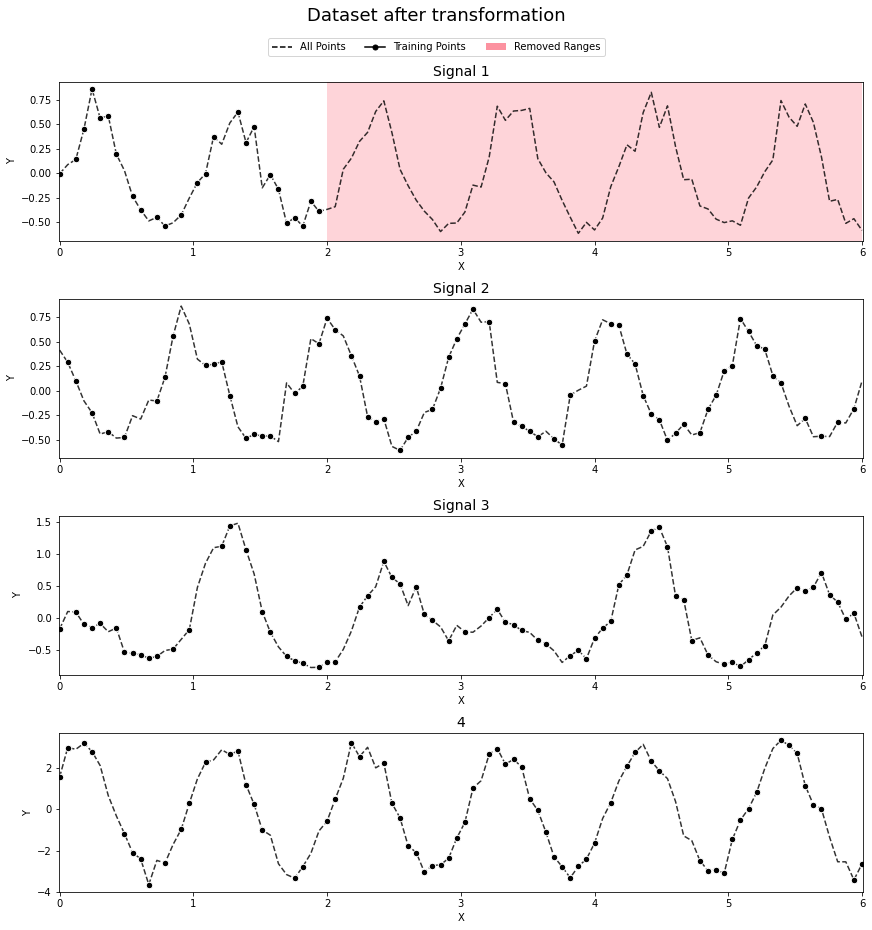

In [16]:
dataset2.plot(title='Dataset after transformation', transformed=True);

In [17]:
model2 = mogptk.MOSM(dataset2, Q=2)
model2.init_parameters('BNSE')
model2.train(method='Adam', iters=600, verbose=True)


Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 4
‣ Mixtures: 2
‣ Training points: 235
‣ Parameters: 48
‣ Initial NLL: 3.091

Optimization finished in 0.40 minutes
‣ Function evaluations: 600
‣ Final NLL: -0.149


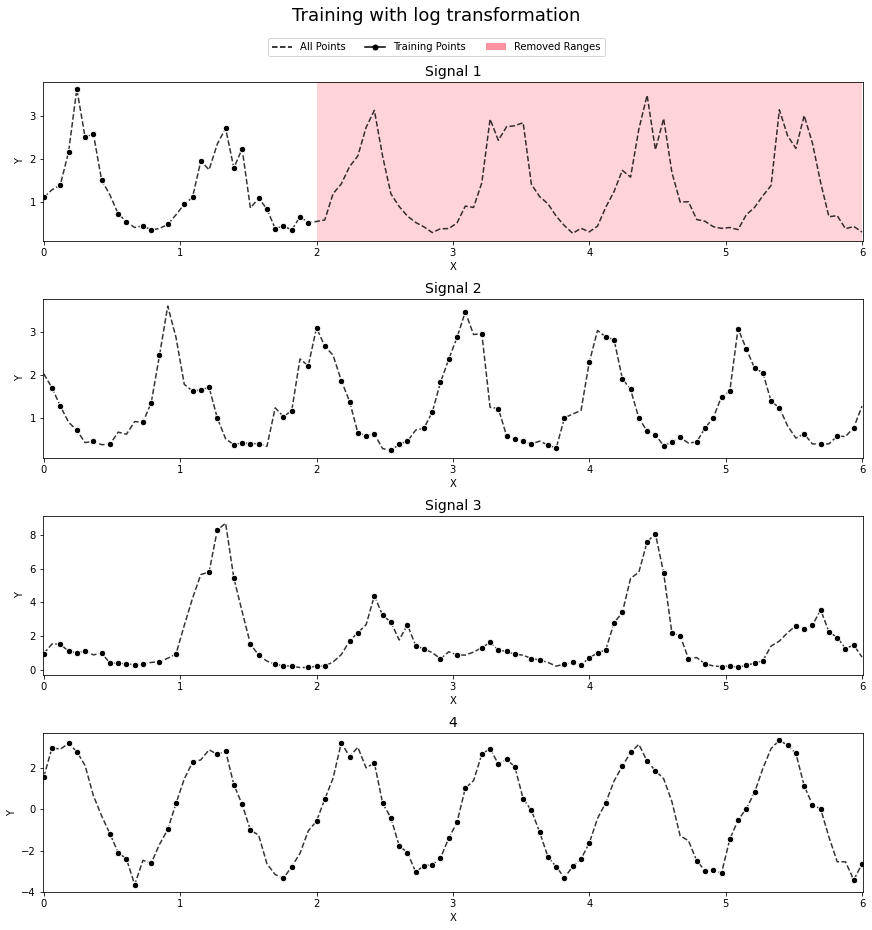

In [18]:
x_pred = [t for i in range(len(dataset2))]
model2.predict(x_pred)
dataset2.plot(title='Training with log transformation');

## Load CSV

The toolkit also allows us to load datasets directly to the model from a CSV file with [`mogptk.LoadCSV`](https://games-uchile.github.io/mogptk/data.html#mogptk.data.LoadCSV), where we specify the filename and the name of the columns for input and output and it returns a Data class object. As an example, let us load the price of oil and gold.

For more information see [01-Data Loading](https://github.com/GAMES-UChile/mogptk/blob/master/examples/01_Data_Loading.ipynb).

In [19]:
oil = mogptk.LoadCSV(filename='data/gonu/brent-daily.csv',
                     x_col='Date', y_col='Price', name='Oil')

gold = mogptk.LoadCSV(filename='data/gonu/lmba-gold-usd-am-daily.csv',
                      x_col='Date', y_col='Price', name='Gold',
                      na_values='.')

dataset3 = mogptk.DataSet(oil, gold)

Once the data is loaded, the toolkit can: filter, agregate by days, remove ranges and set prediction ranges by specifying the date range rather than the internal values used as inputs.

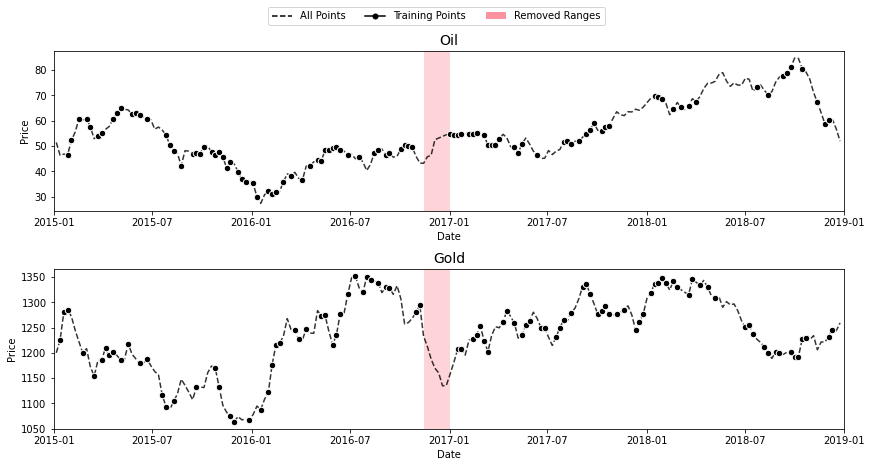

In [20]:
for channel in dataset3:
    # filter by date
    channel.filter('2015-01-01', '2018-12-31')
    
    # agregate from daily to weekly
    channel.aggregate('7D')
    
    # detrend the data set using a first-degree polynomial
    channel.transform(mogptk.TransformDetrend(degree=1))
    
    # remove by date range
    channel.remove_range('2016-11-15', '2017-01-01')
    channel.remove_randomly(pct=0.5)
    
    # set prediction range by date
    channel.set_prediction_range('2015-01-01', '2018-12-31', step='1D')
    
dataset3.plot();

We can now train the model and set a prediction range by date.

In [21]:
model3 = mogptk.MOSM(dataset3, Q=3)
model3.init_parameters('BNSE')
model3.train(method='Adam', iters=1000, verbose=True)


Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 2
‣ Mixtures: 3
‣ Training points: 201
‣ Parameters: 36
‣ Initial NLL: 3.781

Optimization finished in 0.36 minutes
‣ Function evaluations: 1000
‣ Final NLL: 3.575


Next we can predict and plot our model.

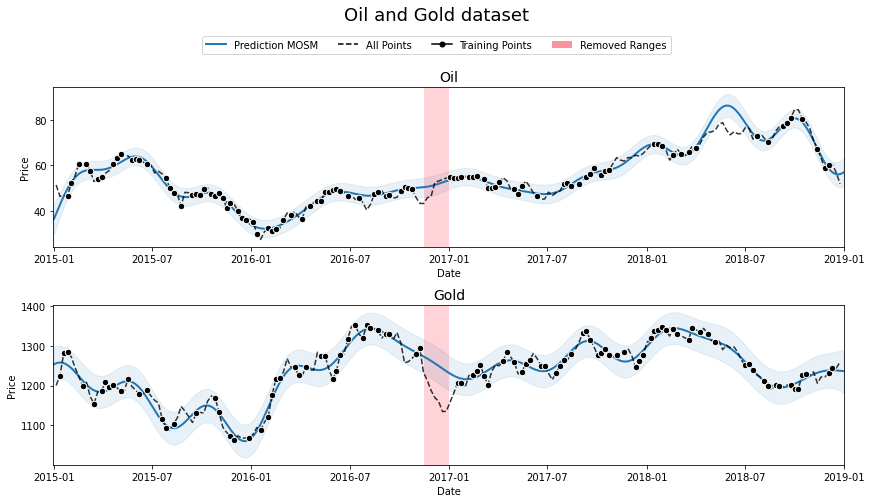

In [22]:
model3.predict()
dataset3.plot(title='Oil and Gold dataset');

## Load/Save Models

Models can be saved with [`mogptk.Model.save`](https://games-uchile.github.io/mogptk/model.html#mogptk.model.Model.save) and loaded with [`mogptk.LoadModel`](https://games-uchile.github.io/mogptk/model.html#mogptk.model.LoadModel)

In [23]:
# save model
model3.save('mosm_example')

In [24]:
# load model
loaded_model = mogptk.LoadModel('mosm_example')

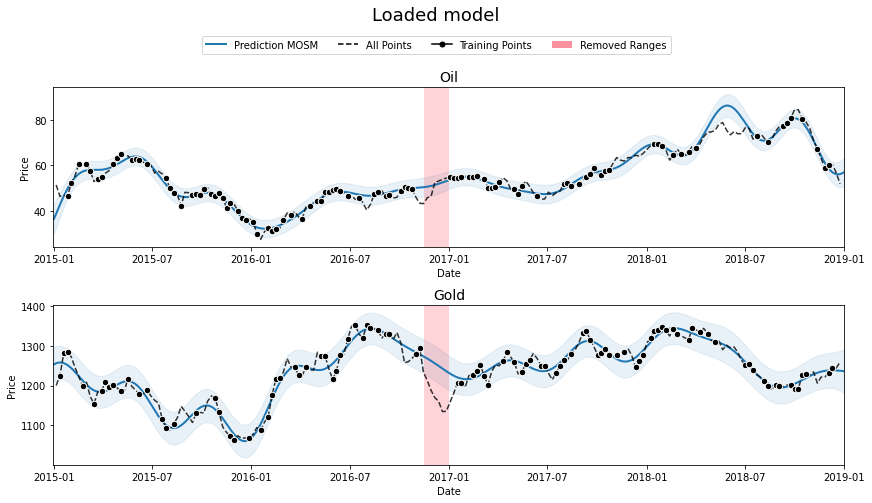

In [25]:
loaded_model.dataset.plot(title='Loaded model');